In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
import math
import glob

In [2]:
class Left_Right:
    L_p = []
    R_p = []
    last_L_points = []
    last_R_points = []
    
    def __init__(self,  L_p, R_p, last_L_points, last_R_points):
        self.L_p = L_p
        self.R_p = R_p
        self.last_L_points = last_L_points
        self.last_R_points = last_R_points

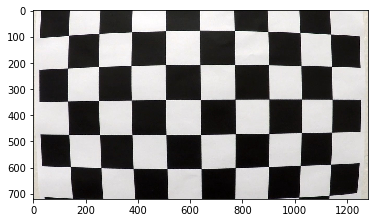

In [3]:
calib_image = mpimg.imread(r'C:\Users\pramo\Documents\Project4\camera_cal\calibration1.jpg')
plt.imshow(calib_image)

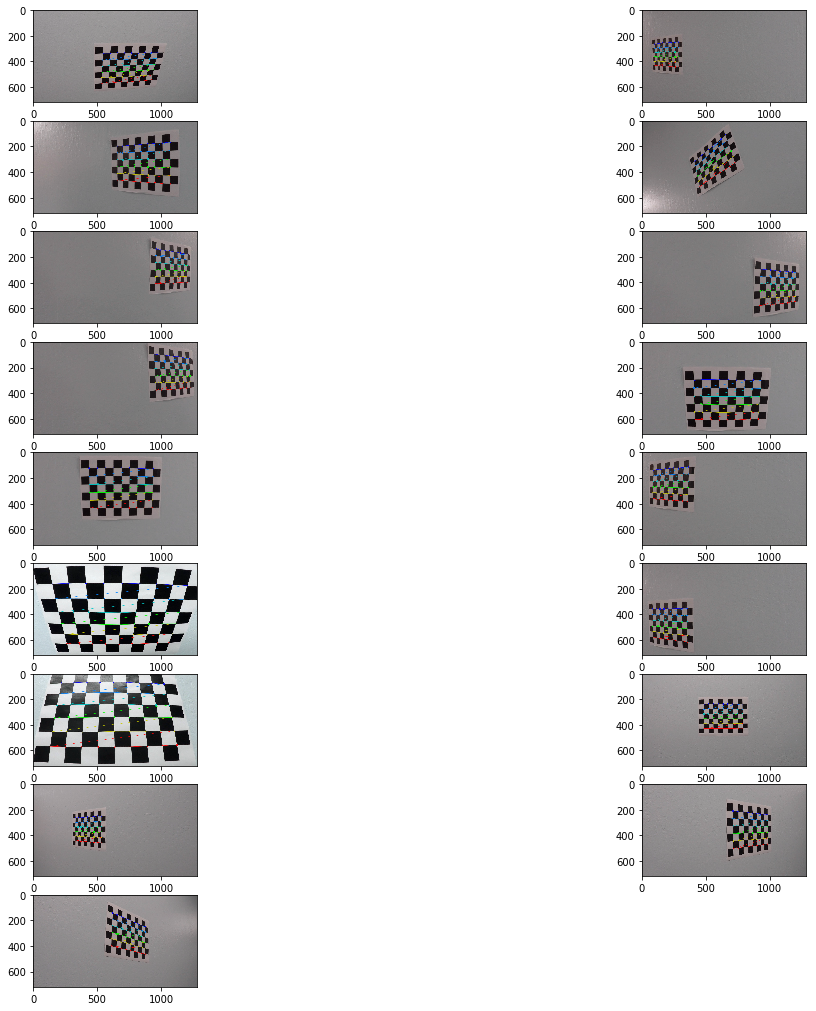

In [4]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images
images = glob.glob(r'C:\Users\pramo\Documents\Project4\camera_cal\calibration*.jpg')
show_images = []
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)       
        show_images.append (img)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

       
fig=plt.figure(figsize=(20, 20))
columns = 2
rows = 10
for i in range(len(show_images)):
    j= i+1
    img = show_images[i].squeeze()
    fig.add_subplot(rows, columns, j)
    plt.imshow(img, cmap="gray")
plt.show()

In [5]:
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [6]:
def cal_undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def gray_image(img):
    thresh = (200, 220)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary

def abs_sobel_img(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray , cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray , cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    abs_sobel_output = np.zeros_like(scaled_sobel)
    abs_sobel_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return abs_sobel_output

def hls_select(img, thresh_min=0, thresh_max=255):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh_min) & (s_channel <= thresh_max)] = 1
    return binary_output

#hls_binary = hls_select(image, thresh=(90, 255))
def wrap_transform(img, inverse ='TRUE'):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    if inverse == 'FALSE':
        M = cv2.getPerspectiveTransform(src, dst)
    if inverse == 'TRUE':
        M = cv2.getPerspectiveTransform(dst, src)
        
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

In [7]:
def combined_image(img): 
    undisort_image = cal_undistort(img, mtx, dist)
    W_image = wrap_transform(undisort_image, inverse ='FALSE')
    grayimage  = gray_image(W_image ) 
    sobelx = abs_sobel_img(W_image,'x', 20, 255)
    s_binary = hls_select(W_image, 150, 255)
    color_binary = np.dstack(( np.zeros_like(sobelx), sobelx, s_binary)) * 255
    combined_binary = np.zeros_like(sobelx)
    combined_binary[(s_binary == 1) | (sobelx == 1) | (grayimage == 1)] = 1
    return undisort_image, sobelx, s_binary, combined_binary, color_binary

In [8]:
def hist(img):
    return np.sum(img[img.shape[0]//2:,:], axis=0)

In [9]:
def find_lane_pixels(binary_warped, image_show = True):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 20
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if image_show == True:
        
        #Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            #Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit

In [10]:
def fit_poly(img_shape, left_fitn, right_fitn):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fitn[0]*ploty**2 + left_fitn[1]*ploty + left_fitn[2]
    right_fitx = right_fitn[0]*ploty**2 + right_fitn[1]*ploty + right_fitn[2]
    return left_fitx, right_fitx, ploty

In [11]:
def fit_polynomial(binary_warped, left_fit, right_fit, image_show = True):
    # Find our lane pixels first
    margin = 20
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
       
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Color in left and right line pixels
    
    left_fitn = np.polyfit(lefty, leftx, 2)
    right_fitn = np.polyfit(righty, rightx, 2)
    
    if image_show == True:
    
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, left_fitn, right_fitn)
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        #Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')

        plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    return left_fitn, right_fitn

In [12]:
def measure_curvature_pixels(img_shape, left_fit, right_fit):    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    leftx, rightx, ploty = fit_poly(img_shape, left_fit, right_fit)
        
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [13]:
def distance(pointL, pointR):
    return math.sqrt((pointL - pointR)**2)

In [14]:
def Sanity_Check(img_shape, left_fit, right_fit): 
    
        xm_per_pix = 3.7/700 # meters per pixel in x dimension    
        ploty = np.linspace(0, 719, num=720)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        left_fitx, right_fitx, ploty = fit_poly(img_shape, left_fit, right_fit)
        
        left_fitx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
        right_fitx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
        
        last_element_L = left_fitx[-1] 
        last_element_R = right_fitx [-1]
        #print(last_element_L)
        mid_element_L = left_fitx[-360] 
        mid_element_R = right_fitx [-360] 
        first_element_L = left_fitx[-720] 
        first_element_R = right_fitx [-720]
        
        b_dist = (distance(last_element_L, last_element_R)*xm_per_pix)
        m_dist  = (distance(mid_element_L, mid_element_R)*xm_per_pix)
        t_dist  = (distance(first_element_L, first_element_R)*xm_per_pix)        
        return b_dist, m_dist, t_dist

In [15]:
def draw_poly(u_imag, binary_warped, left_fit, right_fit):                 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, left_fit, right_fit)     
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    pts_left = np.array([pts_left], np.int32)
    pts_right = np.array([pts_right], np.int32)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, pts_left, 0, (255,0,0), 40)
    cv2.polylines(color_warp, pts_right, 0, (255,0,0), 40)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    un_warped = wrap_transform(color_warp, inverse = 'TRUE') 
    # Combine the result with the original image
    out_img = cv2.addWeighted(u_imag, 1, un_warped, 0.3, 0)
    return out_img

In [16]:
def process_image(image):     
    left_fit = [] 
    right_fit = []
    undisort_image, sobelx, s_binary, combined_binary, color_binary = combined_image(image)
    
    if len(Left_Right.L_p) == 0 or  len(Left_Right.R_p) == 0:
        left_fit, right_fit = find_lane_pixels(combined_binary, image_show = False)       
    else:
        left_fit = Left_Right.L_p
        right_fit = Left_Right.R_p        
        left_fit, right_fit = fit_polynomial(combined_binary, left_fit, right_fit, image_show = False) 
        
    b_dist, m_dist, t_dist = Sanity_Check(combined_binary.shape, left_fit, right_fit)        
    mean = (b_dist + m_dist + t_dist)/3
    #print (t_dist) 
    if (3.8 > mean > 3.1) and (3.5 > t_dist > 3.1):
        Left_Right.L_p = left_fit
        Left_Right.R_p = right_fit          
    else: 
        left_fit = Left_Right.L_p
        right_fit = Left_Right.R_p
        
    L_curvature, R_Curvature =  measure_curvature_pixels(combined_binary.shape, left_fit, right_fit)
    curvature  = (L_curvature + R_Curvature)/2   
    result = draw_poly(undisort_image, combined_binary, left_fit, right_fit)
    TEXT = 'Center Curvature = %f(m)' %curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, TEXT, (50,50), font, 1, (0, 255, 0), 2)
    return result

In [17]:
Video = True
if Video == True: 
    output = 'project_video_out.mp4'
    clip = VideoFileClip('project_video.mp4')
    yellow_clip = clip.fl_image(process_image)
    yellow_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:49<00:00, 11.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [18]:
image_test = False
if image_test == True:    
    img = cv2.imread(r'C:\Users\pramo\Documents\Project4\test_images\test1.jpg')
    undisort_image, sobelx, s_binary, combined_binary, color_binary = combined_image(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(combined_binary, cmap="gray")
    ax2.set_title('Combined Binary', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)